In [1]:
import math
import os
import re
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
def read(file_name):
    data_dir = '/Users/keiji/work/kaggle/sales1c/'
    pickle = data_dir + file_name + '.pickle'
    if os.path.exists(pickle):
        return pd.read_pickle(pickle)
    df = pd.read_csv(data_dir + file_name)
    df.to_pickle(pickle)
    return df

df_icats = read('item_categories.csv')
df_items = read('items.csv')
df_shops = read('shops.csv')
df_test = read('test.csv.gz')
df_sales = read('sales_train.csv.gz')

In [3]:
# Drop outliers.
# I'm not sure if this really matters.
df_sales = df_sales[df_sales.item_price < 60000]
df_sales = df_sales[df_sales.item_cnt_day < 700]

In [4]:
df_sales['item_sales'] = df_sales.item_price * df_sales.item_cnt_day

In [5]:
unique_shop_id = df_sales[['date_block_num', 'shop_id']].drop_duplicates().reset_index(drop=True)
unique_item_id = df_sales[['date_block_num', 'item_id']].drop_duplicates().reset_index(drop=True)
df_train = (
    pd.DataFrame({'date_block_num': np.arange(34)})
    .merge(unique_shop_id, how='left', on='date_block_num')
    .merge(unique_item_id, how='left', on='date_block_num')
    .merge(df_items[['item_id', 'item_category_id']], how='left', on='item_id')
    .sort_values(by=['date_block_num', 'shop_id', 'item_id'])
    .reset_index(drop=True)
)

df_agg = (
    df_sales.groupby(['date_block_num', 'shop_id', 'item_id'])
    .agg({
        'item_cnt_day': 'sum',
        'item_price': 'median',
        'item_sales': 'sum',
    })
    .reset_index()
    .rename(columns={
        'item_cnt_day': 'item_cnt_month',
        'item_price': 'median_price',
        'item_sales': 'item_sales_month',
    })
)
df_train = df_train.merge(df_agg, how='left', on=['date_block_num', 'shop_id', 'item_id'])
df_train.item_cnt_month.fillna(0.0, inplace=True)
df_train.item_sales_month.fillna(0.0, inplace=True)

df_agg = (
    df_sales.groupby(['date_block_num', 'item_id'])
    .agg({
        'item_cnt_day': 'sum',
        'item_price': 'median',
        'item_sales': 'sum',
    })
    .reset_index()
    .rename(columns={
        'item_cnt_day': 'item_cnt_month_allshops',
        'item_price': 'median_price_allshops',
        'item_sales': 'item_sales_month_allshops',
    })
)
df_train = df_train.merge(df_agg, how='left', on=['date_block_num', 'item_id'])
df_train.median_price.fillna(df_train.median_price_allshops, inplace=True)

for col in ['shop_id', 'item_id', 'item_category_id']:
    df_agg = (
        df_train.groupby(['date_block_num', col])
        .item_cnt_month
        .mean()
        .reset_index()
        .rename(columns={'item_cnt_month': 'meanenc_' + col})
    )
    df_train = df_train.merge(df_agg, how='left', on=['date_block_num', col])
    
    df_agg = (
        df_train.groupby([col])
        .date_block_num
        .min()
        .reset_index()
        .rename(columns={'date_block_num': col + '_age'})
    )
    df_train = df_train.merge(df_agg, how='left', on=[col])
    df_train[col + '_age'] = df_train.date_block_num - df_train[col + '_age']
    

df_train.head().T

,0,1,2,3,4
date_block_num,0.000000,0.000000,0.000000,0.000000,0.000000
shop_id,0.000000,0.000000,0.000000,0.000000,0.000000
item_id,19.000000,27.000000,28.000000,29.000000,32.000000
item_category_id,40.000000,19.000000,30.000000,23.000000,40.000000
median_price,28.000000,2499.000000,549.000000,2499.000000,221.000000
item_sales_month,0.000000,0.000000,0.000000,0.000000,1326.000000
item_cnt_month,0.000000,0.000000,0.000000,0.000000,6.000000
median_price_allshops,28.000000,2499.000000,549.000000,2499.000000,349.000000
item_sales_month_allshops,28.000000,16275.000000,4392.000000,9387.000000,101515.860000
item_cnt_month_allshops,1.000000,7.000000,8.000000,4.000000,299.000000


In [6]:
#df_train['price_delta'] = df_train.median_price - df_train.median_price_allshops
#df_train['price_ratio'] = df_train.median_price / df_train.median_price_allshops
df_train['item_cnt_ratio'] = df_train.item_cnt_month / df_train.item_cnt_month_allshops
df_train['item_cnt_ratio'].fillna(0.0, inplace=True)
#df_train['item_sales_ratio'] = df_train.item_sales_month / df_train.item_sales_month_allshops
#df_train['item_sales_ratio'].fillna(0.0, inplace=True)
df_train.head().T

,0,1,2,3,4
date_block_num,0.000000,0.000000,0.000000,0.000000,0.000000
shop_id,0.000000,0.000000,0.000000,0.000000,0.000000
item_id,19.000000,27.000000,28.000000,29.000000,32.000000
item_category_id,40.000000,19.000000,30.000000,23.000000,40.000000
median_price,28.000000,2499.000000,549.000000,2499.000000,221.000000
item_sales_month,0.000000,0.000000,0.000000,0.000000,1326.000000
item_cnt_month,0.000000,0.000000,0.000000,0.000000,6.000000
median_price_allshops,28.000000,2499.000000,549.000000,2499.000000,349.000000
item_sales_month_allshops,28.000000,16275.000000,4392.000000,9387.000000,101515.860000
item_cnt_month_allshops,1.000000,7.000000,8.000000,4.000000,299.000000


In [7]:
df_train.isnull().sum()

date_block_num               0
shop_id                      0
item_id                      0
item_category_id             0
median_price                 0
item_sales_month             0
item_cnt_month               0
median_price_allshops        0
item_sales_month_allshops    0
item_cnt_month_allshops      0
meanenc_shop_id              0
shop_id_age                  0
meanenc_item_id              0
item_id_age                  0
meanenc_item_category_id     0
item_category_id_age         0
item_cnt_ratio               0
dtype: int64

In [8]:
from functools import partial

def rename_column(index, col_name):
    if col_name in ['shop_id', 'item_id']:
        return col_name
    return '{}_{}'.format(col_name, index)
    
def make_features(label_block):
    label_df = df_train.loc[df_train.date_block_num == label_block, ['shop_id', 'item_id', 'item_cnt_month']].reset_index(drop=True)
    y = label_df.item_cnt_month#.map(lambda x: max(0, min(40, x)))
    return make_features2(label_block, label_df), y

def make_features2(label_block, label_df):
    X = label_df[['shop_id', 'item_id']]
    # Only 1 month ago and 2 months ago
    for i in range(1, 3):
        feature_block = label_block - i
        dff = (
            df_train.loc[df_train.date_block_num == feature_block]
            .drop(['date_block_num', 'item_category_id'], axis=1)
            .rename(partial(rename_column, i), axis='columns')
        )
        X = X.merge(dff, how='left', on=['shop_id', 'item_id'])
    X['item_cnt_month_delta'] = X['item_cnt_month_1'] - X['item_cnt_month_2']
    X['item_cnt_month_allshops_delta'] = X['item_cnt_month_allshops_1'] - X['item_cnt_month_allshops_2']
    X.drop(['shop_id', 'item_id'], axis=1, inplace=True)
    X.fillna(0.0, inplace=True)
    return X

In [9]:
VALIDATION_BLOCK = 33
TRAINING_BLOCK_RANGE = range(20, VALIDATION_BLOCK)

Xs = []
ys = []
for label_block in TRAINING_BLOCK_RANGE:
    X, y = make_features(label_block)
    Xs.append(X)
    ys.append(y)

X_train = pd.concat(Xs)
y_train = pd.concat(ys)
X_train.head(10).T

,0,1,2,3,4,5,6,7,8,9
median_price_1,0.0,4490.000000,0.0,58.000000,0.0,0.0,0.0,0.0,169.000000,383.970000
item_sales_month_1,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
item_cnt_month_1,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
median_price_allshops_1,0.0,4490.000000,0.0,58.000000,0.0,0.0,0.0,0.0,169.000000,383.970000
item_sales_month_allshops_1,0.0,4490.000000,0.0,58.000000,0.0,0.0,0.0,0.0,2028.000000,5355.670000
item_cnt_month_allshops_1,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,0.0,12.000000,13.000000
meanenc_shop_id_1,0.0,0.150244,0.0,0.150244,0.0,0.0,0.0,0.0,0.150244,0.150244
shop_id_age_1,0.0,19.000000,0.0,19.000000,0.0,0.0,0.0,0.0,19.000000,19.000000
meanenc_item_id_1,0.0,0.019608,0.0,0.019608,0.0,0.0,0.0,0.0,0.235294,0.254902
item_id_age_1,0.0,4.000000,0.0,0.000000,0.0,0.0,0.0,0.0,18.000000,18.000000


In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3526673 entries, 0 to 218654
Data columns (total 28 columns):
median_price_1                   float64
item_sales_month_1               float64
item_cnt_month_1                 float64
median_price_allshops_1          float64
item_sales_month_allshops_1      float64
item_cnt_month_allshops_1        float64
meanenc_shop_id_1                float64
shop_id_age_1                    float64
meanenc_item_id_1                float64
item_id_age_1                    float64
meanenc_item_category_id_1       float64
item_category_id_age_1           float64
item_cnt_ratio_1                 float64
median_price_2                   float64
item_sales_month_2               float64
item_cnt_month_2                 float64
median_price_allshops_2          float64
item_sales_month_allshops_2      float64
item_cnt_month_allshops_2        float64
meanenc_shop_id_2                float64
shop_id_age_2                    float64
meanenc_item_id_2          

In [11]:
reg = LGBMRegressor()
reg.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=31, objective=None, random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)

In [12]:
def clip(s):
    return s.map(lambda x: max(0.0, min(20.0, x)))

def rmse(x, y):
    return math.sqrt(mean_squared_error(clip(x), clip(y)))

if VALIDATION_BLOCK < 34:
    X_val, y_val = make_features(VALIDATION_BLOCK)
    y_pred = pd.Series(reg.predict(X_val))
    print('validation RMSE score:', rmse(y_val, y_pred))

validation RMSE score: 0.9931166476193554


In [13]:
y_train_p = pd.Series(reg.predict(X_train))
print('training RMSE score', rmse(y_train, y_train_p))

training RMSE score 0.933911321356238


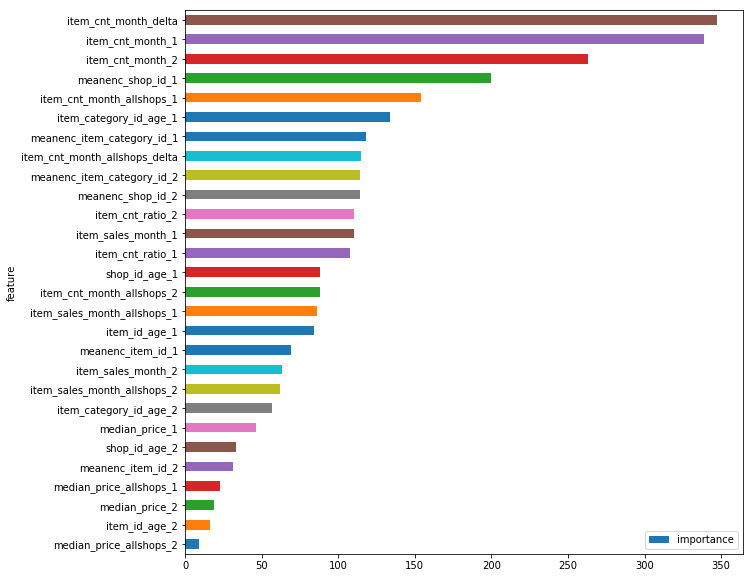

In [14]:
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': reg.feature_importances_})
feature_importances.sort_values(by='importance', ascending=True, inplace=True)
feature_importances.plot(x='feature', y='importance', kind='barh', sort_columns=True, figsize=(10,10))

In [15]:
if VALIDATION_BLOCK == 34:
    X_test = make_features2(VALIDATION_BLOCK, df_test)
    y_test_pred = clip(pd.Series(reg.predict(X_test)))
    pd.DataFrame(y_test_pred).info()
    y_test_pred.head()

In [16]:
    df_submit = pd.DataFrame(df_test.loc[:,'ID'])
    df_submit['item_cnt_month'] = y_test_pred
    df_submit.to_csv('lgbm2.csv', index=False)

NameError: name 'y_test_pred' is not defined